In [1]:
from __future__ import print_function
import numpy as np # For numerical fast numerical calculations
import matplotlib.pyplot as plt # For making plots
import pandas as pd # Deals with data
import seaborn as sns # Makes beautiful plots
import keras 
import sys 
from pandas import pandas as pd
import category_encoders as ce
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd
# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
# Albumentations
import albumentations as A 
# Keras
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 
#visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline
import seaborn as sns
from IPython.display import HTML, Image
import cv2
import os
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

# load data

p_train=pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
p_test=pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

Using TensorFlow backend.


# load datasets and choose image_size

In [2]:
p_train=pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
p_test=pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

target = p_train[['healthy', 'multiple_diseases', 'rust', 'scab']]
test_ids = p_test['image_id']

img_size=224

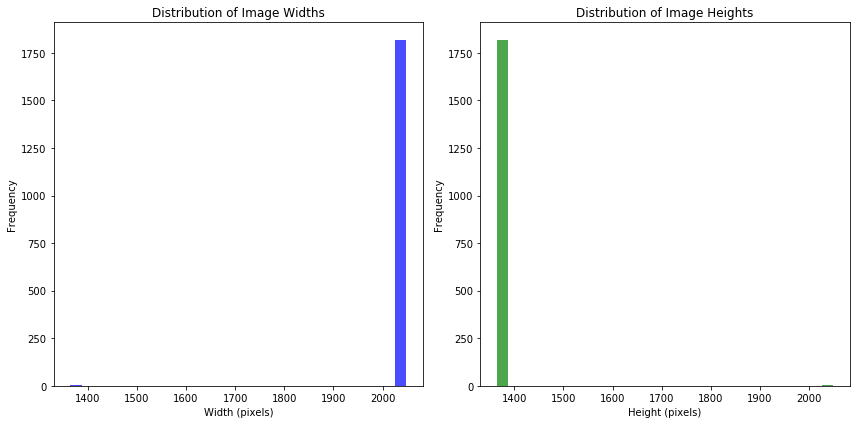

In [3]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

image_dir = '../input/plant-pathology-2020-fgvc7/images/'

# Initialize lists to store image sizes
widths = []
heights = []

# Loop through each image in the training set
for image_id in p_train['image_id']:
    image_path = os.path.join(image_dir, image_id + '.jpg')
    with Image.open(image_path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)
# Create a DataFrame with the image dimensions
image_sizes = pd.DataFrame({'width': widths, 'height': heights})

# Plot the distribution of image widths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(image_sizes['width'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Plot the distribution of image heights
plt.subplot(1, 2, 2)
plt.hist(image_sizes['height'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

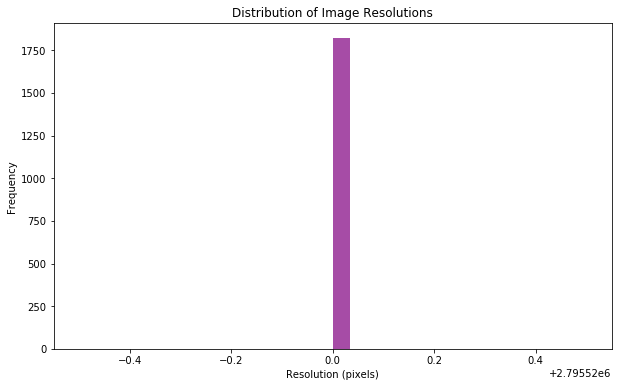

In [4]:
image_dir = '../input/plant-pathology-2020-fgvc7/images/'

# Initialize a list to store image resolutions
resolutions = []

# Loop through each image in the training set
for image_id in p_train['image_id']:
    image_path = os.path.join(image_dir, image_id + '.jpg')
    with Image.open(image_path) as img:
        width, height = img.size
        resolution = width * height
        resolutions.append(resolution)

# Create a DataFrame with the image resolutions
image_resolutions = pd.DataFrame({'resolution': resolutions})

# Plot the distribution of image resolutions
plt.figure(figsize=(10, 6))
plt.hist(image_resolutions['resolution'], bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Resolutions')
plt.xlabel('Resolution (pixels)')
plt.ylabel('Frequency')
plt.show()

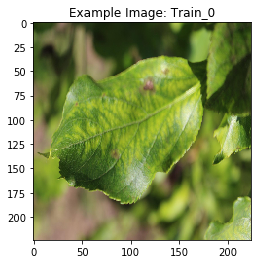

In [5]:

img_size = 224

def load_and_preprocess_image(image_id, base_path='../input/plant-pathology-2020-fgvc7/images/'):
    # Load the image
    img = cv2.imread(os.path.join(base_path, image_id + '.jpg'))
    # Resize the image
    img = cv2.resize(img, (img_size, img_size))
    return img

# Example: Load and preprocess the first image
example_image_id = p_train['image_id'].iloc[0]
example_image = load_and_preprocess_image(example_image_id)
plt.imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))
plt.title(f"Example Image: {example_image_id}")
plt.show()

In [6]:
def extract_color_histogram(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Compute the color histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Example: Extract color histogram for the example image
example_hist = extract_color_histogram(example_image)
print(f"Example Histogram: {example_hist[:5]}")

Example Histogram: [0. 0. 0. 0. 0.]


# Variable Frequency Distributions
### We see below that there are imbalanced classes for the variable multiple_diseases.
### This could distort our model's evaluation metrics so will have to implement a resampling strategy later on

In [7]:
# Data Overview
print(f'Training data shape: {p_train.shape}')
print(f'Test data shape: {p_test.shape}')
print(p_train.head(), "\n")
print(p_test.head())

Training data shape: (1821, 5)
Test data shape: (1821, 1)
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0 

  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4


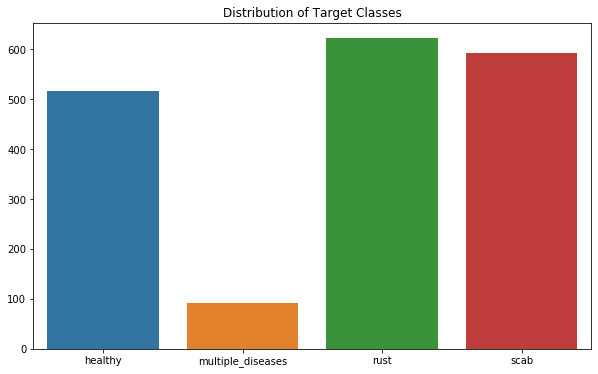

In [8]:
# Target Distribution

target = p_train[['healthy', 'multiple_diseases', 'rust', 'scab']]
target_counts = target.sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Classes')
plt.show()

In [9]:

# Missing Values
print(f'Missing values in training data: {p_train.isnull().sum().sum()}')
print(f'Missing values in test data: {p_test.isnull().sum().sum()}')

Missing values in training data: 0
Missing values in test data: 0


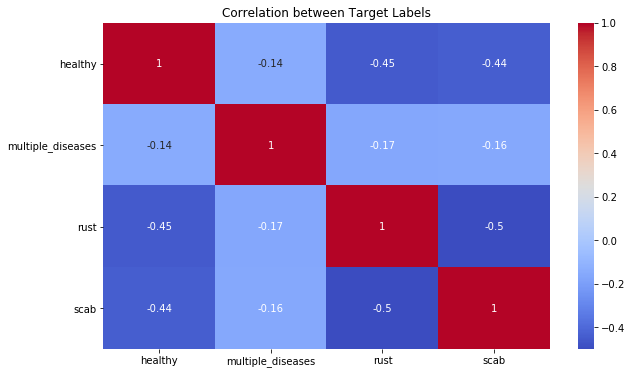

In [10]:
# Target Correlation
correlation = target.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Target Labels')
plt.show()

In [11]:
print(p_train.describe())


           healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000


<Figure size 864x576 with 0 Axes>

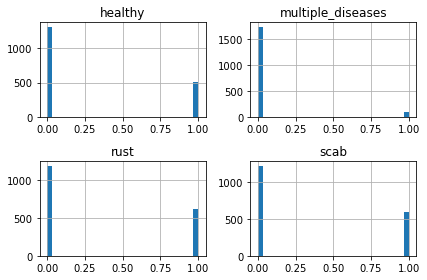

In [12]:
# Visualization of distributions
plt.figure(figsize=(12, 8))

# Histograms for each target class
p_train[['healthy', 'multiple_diseases', 'rust', 'scab']].hist(bins=30)
plt.tight_layout()
plt.show()



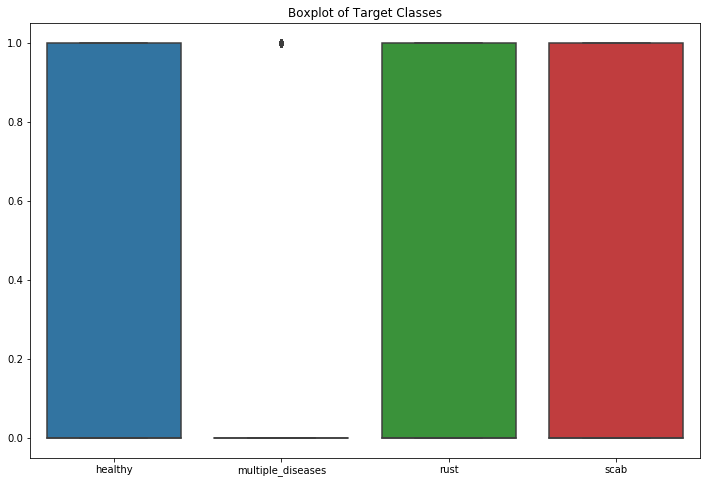

In [13]:
# Boxplots to identify potential outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=p_train[['healthy', 'multiple_diseases', 'rust', 'scab']])
plt.title('Boxplot of Target Classes')
plt.show()

In [14]:
!pip install pillow


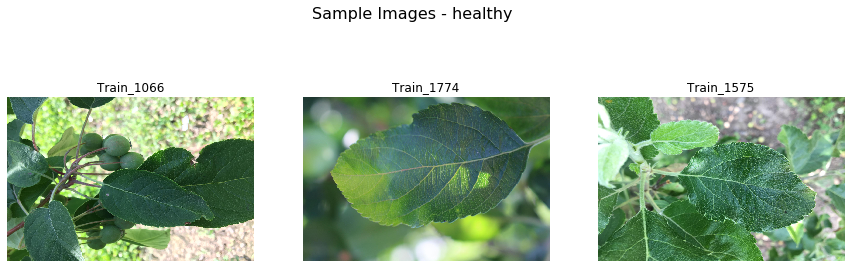

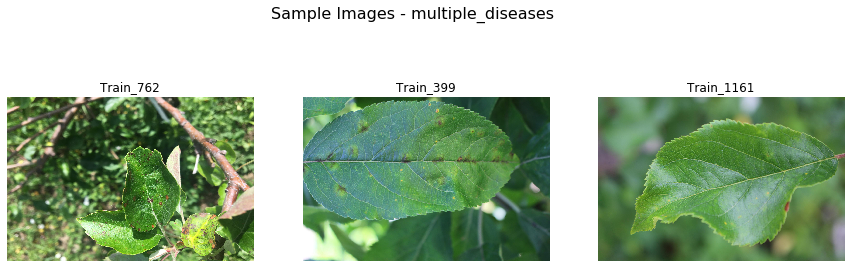

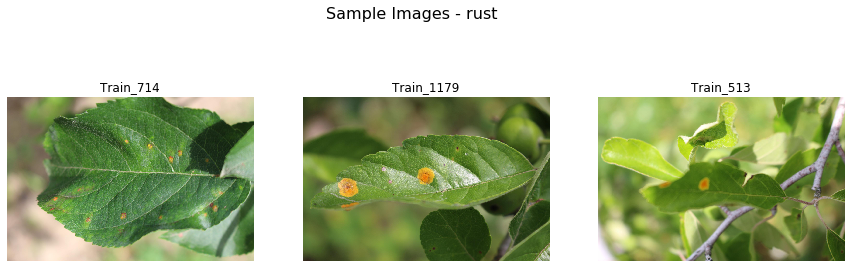

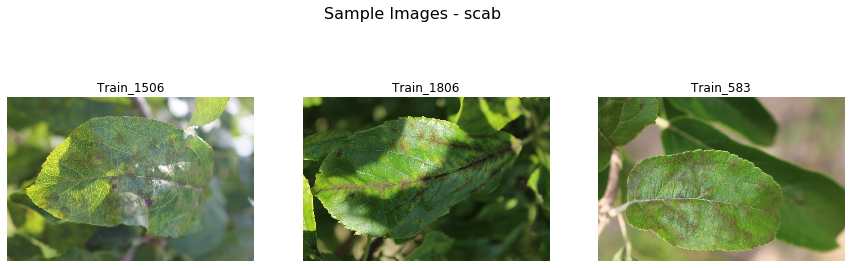

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
def display_images_from_each_category(df, image_dir, num_images=3):
    categories = ['healthy', 'multiple_diseases', 'rust', 'scab']
    
    for category in categories:
        # Filter images for the current category
        sample_images = df[df[category] == 1]['image_id'].sample(num_images, random_state=42)
        
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        fig.suptitle(f'Sample Images - {category}', fontsize=16)
        
        for i, img_id in enumerate(sample_images):
            img_path = os.path.join(image_dir, img_id + '.jpg')
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(img_id)
            axes[i].axis('off')
        
        plt.show()

# Display sample images from each category
image_dir = '../input/plant-pathology-2020-fgvc7/images'
display_images_from_each_category(p_train, image_dir)


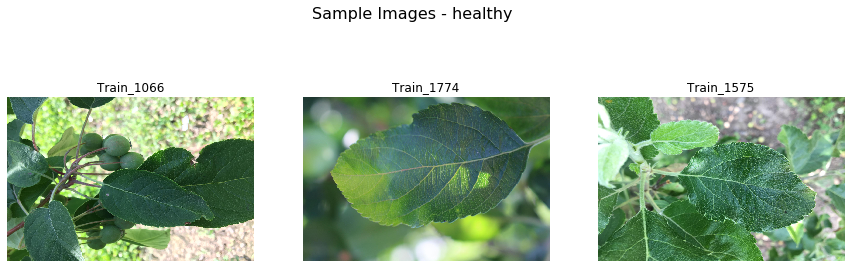

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def display_images_for_category(df, category, image_dir, num_images=3):
    # Filter images for the specified category
    sample_images = df[df[category] == 1]['image_id'].sample(num_images, random_state=42)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f'Sample Images - {category}', fontsize=16)
    
    for i, img_id in enumerate(sample_images):
        img_path = os.path.join(image_dir, img_id + '.jpg')
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_id)
        axes[i].axis('off')
    
    plt.show()

# Load the dataset (example)
p_train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

# Define the image directory
image_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images'

# Display sample images for each category
display_images_for_category(p_train, 'healthy', image_dir)


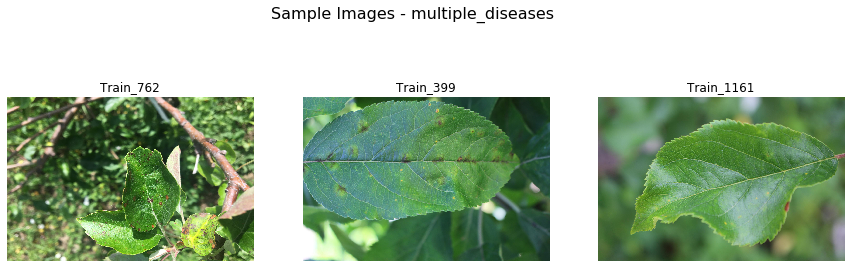

In [17]:
display_images_for_category(p_train, 'multiple_diseases', image_dir)


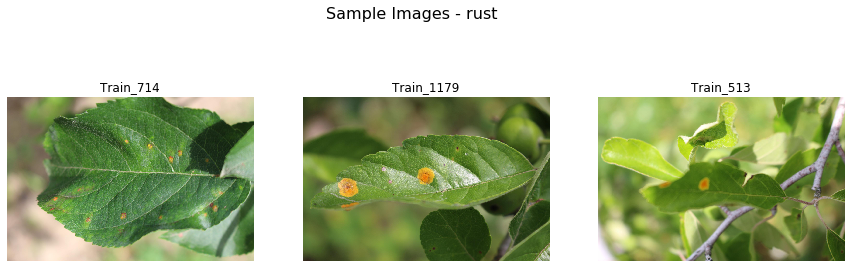

In [18]:
display_images_for_category(p_train, 'rust', image_dir)


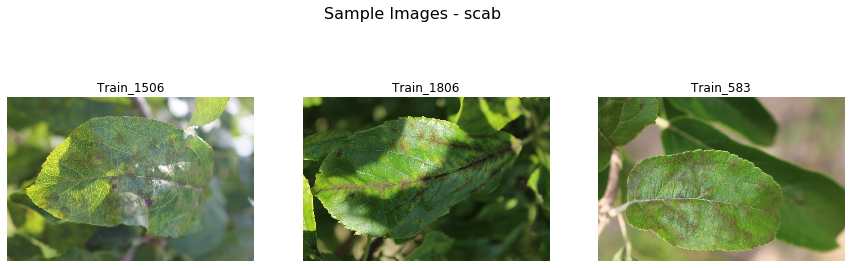

In [19]:
display_images_for_category(p_train, 'scab', image_dir)

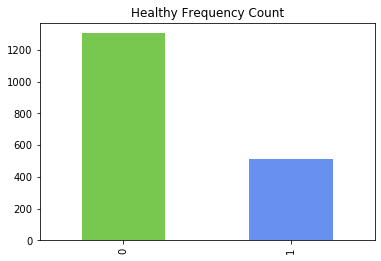

In [20]:
colors=['#78C850','#6890F0']
p_train['healthy'].value_counts().plot(kind='bar',title='Healthy Frequency Count',color=colors)

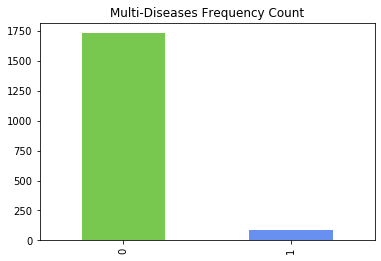

In [21]:
p_train['multiple_diseases'].value_counts().plot(kind='bar',title='Multi-Diseases Frequency Count',color=colors)

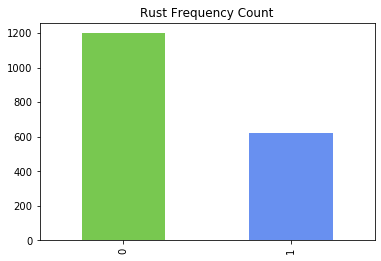

In [22]:
p_train['rust'].value_counts().plot(kind='bar',title='Rust Frequency Count',color=colors)

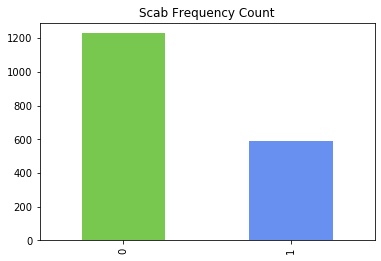

In [23]:
p_train['scab'].value_counts().plot(kind='bar',title='Scab Frequency Count',color=colors)


# Image processing

Train Shape: (1821, 224, 224, 3)
Test Shape: (1821, 224, 224, 3)


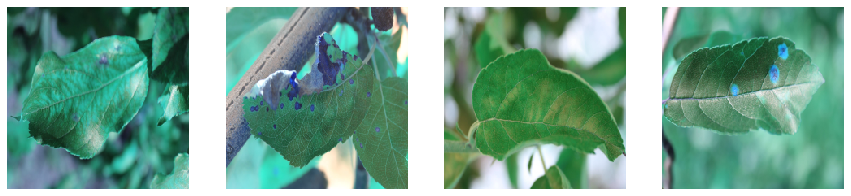

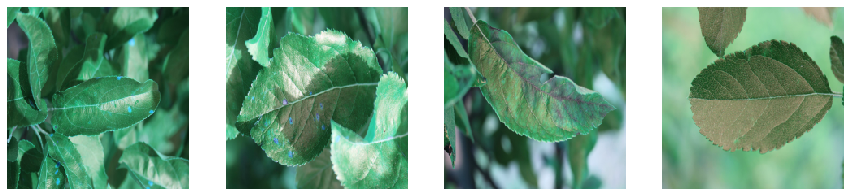

In [24]:
train_image=[]
for name in p_train['image_id']:
    path='../input/plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    train_image.append(image)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(train_image[i])
    
    
test_image=[]
for name in p_test['image_id']:
    path='../input/plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    test_image.append(image)
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(test_image[i])    

from keras.preprocessing.image import img_to_array

x_train = np.ndarray(shape=(len(train_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in train_image:
    x_train[i]=img_to_array(image)
    x_train[i]=train_image[i]
    i=i+1
x_train=x_train/255
print('Train Shape: {}'.format(x_train.shape))

x_test = np.ndarray(shape=(len(test_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in test_image:
    x_test[i]=img_to_array(image)
    x_test[i]=test_image[i]
    i=i+1
    
x_test=x_test/255
print('Test Shape: {}'.format(x_test.shape))

# Split training set to create a validation set

In [25]:
y = p_train.copy()
del y['image_id']
y.head()


y_train = np.array(y.values)
print(y_train.shape,y_train[0])

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=115)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

(1821, 4) [0 0 0 1]


((1456, 224, 224, 3), (365, 224, 224, 3), (1456, 4), (365, 4))

# Handle imbalanced dataset classes


In [26]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 定义 ImageDataGenerator 实例
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 生成新的训练数据
def generate_balanced_data(X_train, y_train, batch_size=32):
    # 计算各类别样本数目
    class_counts = y_train.sum(axis=0)
    max_class_count = class_counts.max()
    
    new_X_train = []
    new_y_train = []
    
    for i in range(y_train.shape[1]):  # 遍历每一个类别
        class_indices = np.where(y_train[:, i] == 1)[0]
        class_X = X_train[class_indices]
        class_y = y_train[class_indices]
        
        num_samples_generated = 0
        while num_samples_generated < max_class_count:
            for x_batch, y_batch in datagen.flow(class_X, class_y, batch_size=batch_size):
                new_X_train.append(x_batch)
                new_y_train.append(y_batch)
                num_samples_generated += x_batch.shape[0]
                if num_samples_generated >= max_class_count:
                    break

    new_X_train = np.concatenate(new_X_train)
    new_y_train = np.concatenate(new_y_train)
    
    return new_X_train[:max_class_count * y_train.shape[1]], new_y_train[:max_class_count * y_train.shape[1]]

# 使用数据增强生成平衡数据集
x_train_balanced, y_train_balanced = generate_balanced_data(x_train, y_train)

print('Balanced Train Shape:', x_train_balanced.shape)
print('Balanced Train Class Distribution:', y_train_balanced.sum(axis=0))


Balanced Train Shape: (2004, 224, 224, 3)
Balanced Train Class Distribution: [532 508 501 463]


# Set early stopping parameters and kernel regularizer value

In [27]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=10,
                            min_lr=.000001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=10)

reg = .0005

# CNN model

# Image Data Augmentation and fit model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
import random

# Define image size and regularization parameter
img_size = 224  # Image size of 224x224 pixels
reg = 0.01  # Regularization parameter for L2 regularization

# Randomize some hyperparameters for tuning
conv_filters = [32, 64, 128]  # Options for the number of filters in the convolutional layers
dense_units = [128, 256]  # Options for the number of units in the dense layers
dropout_rates = [0.25,0.3,0.35,0.4,0.45,0.5]  # Options for dropout rates
learning_rates = [0.001, 0.0001]  # Options for learning rates

#  select hyperparameters
selected_conv_filter = conv_filters[0]
selected_dense_unit = dense_units[0]
selected_dropout_rate = dropout_rates[0]
selected_learning_rate = learning_rates[0]

# Create the model
model = Sequential([
    # First convolutional layer with a random number of filters
    Conv2D(selected_conv_filter, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), kernel_regularizer=l2(reg)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),  # Use the randomly selected dropout rate

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Flatten and fully connected layers
    Flatten(),
    Dense(selected_dense_unit, activation='relu'),  # Use the randomly selected number of dense units
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(4, activation='softmax')  # The number of neurons in the last layer equals the number of classes
])

# Print model summary
model.summary()

# Compile the model using the randomly selected learning rate
model.compile(optimizer=RMSprop(learning_rate=selected_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the randomly selected hyperparameters
print(f'Selected Conv Filter: {selected_conv_filter}')
print(f'Selected Dense Units: {selected_dense_unit}')
print(f'Selected Dropout Rate: {selected_dropout_rate}')
print(f'Selected Learning Rate: {selected_learning_rate}')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True  # Randomly flip images horizontally
)

# Training the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=24),
    epochs=50,
    steps_per_epoch=x_train.shape[0] // 24,
    verbose=1,
    validation_data=datagen.flow(x_val, y_val, batch_size=24),
    validation_steps=x_val.shape[0] // 24
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 64)     

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import random

# Define image size and regularization parameter
img_size = 224  # Image size of 224x224 pixels
reg = 0.01  # Regularization parameter for L2 regularization

# Randomize some hyperparameters for tuning
conv_filters = [32, 64, 128]  # Options for the number of filters in the convolutional layers
dense_units = [128, 256]  # Options for the number of units in the dense layers
dropout_rates = [0.25,0.3,0.35,0.4,0.45,0.5]  # Options for dropout rates
learning_rates = [0.001, 0.0001]  # Options for learning rates

#  select hyperparameters
selected_conv_filter = conv_filters[1]
selected_dense_unit = dense_units[0]
selected_dropout_rate = dropout_rates[0]
selected_learning_rate = learning_rates[0]

# Create the model
model = Sequential([
    # First convolutional layer with a random number of filters
    Conv2D(selected_conv_filter, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), kernel_regularizer=l2(reg)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),  # Use the randomly selected dropout rate

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Flatten and fully connected layers
    Flatten(),
    Dense(selected_dense_unit, activation='relu'),  # Use the randomly selected number of dense units
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(4, activation='softmax')  # The number of neurons in the last layer equals the number of classes
])

# Print model summary
model.summary()

# Compile the model using the randomly selected learning rate
model.compile(optimizer=RMSprop(learning_rate=selected_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the randomly selected hyperparameters
print(f'Selected Conv Filter: {selected_conv_filter}')
print(f'Selected Dense Units: {selected_dense_unit}')
print(f'Selected Dropout Rate: {selected_dropout_rate}')
print(f'Selected Learning Rate: {selected_learning_rate}')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True  # Randomly flip images horizontally
)

# Training the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=24),
    epochs=50,
    steps_per_epoch=x_train.shape[0] // 24,
    verbose=1,
    validation_data=datagen.flow(x_val, y_val, batch_size=24),
    validation_steps=x_val.shape[0] // 24
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 222, 222, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 108, 108, 64)     

In [34]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import random

# Define image size and regularization parameter
img_size = 224  # Image size of 224x224 pixels
reg = 0.01  # Regularization parameter for L2 regularization

# Randomize some hyperparameters for tuning
conv_filters = [32, 64, 128]  # Options for the number of filters in the convolutional layers
dense_units = [128, 256]  # Options for the number of units in the dense layers
dropout_rates = [0.25,0.3,0.35,0.4,0.45,0.5]  # Options for dropout rates
learning_rates = [0.001, 0.0001]  # Options for learning rates

#  select hyperparameters
selected_conv_filter = conv_filters[2]
selected_dense_unit = dense_units[0]
selected_dropout_rate = dropout_rates[0]
selected_learning_rate = learning_rates[0]
# Create the model
model = Sequential([
    # First convolutional layer with a random number of filters
    Conv2D(selected_conv_filter, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), kernel_regularizer=l2(reg)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),  # Use the randomly selected dropout rate

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Flatten and fully connected layers
    Flatten(),
    Dense(selected_dense_unit, activation='relu'),  # Use the randomly selected number of dense units
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(4, activation='softmax')  # The number of neurons in the last layer equals the number of classes
])

# Print model summary
model.summary()

# Compile the model using the randomly selected learning rate
model.compile(optimizer=RMSprop(learning_rate=selected_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the randomly selected hyperparameters
print(f'Selected Conv Filter: {selected_conv_filter}')
print(f'Selected Dense Units: {selected_dense_unit}')
print(f'Selected Dropout Rate: {selected_dropout_rate}')
print(f'Selected Learning Rate: {selected_learning_rate}')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True  # Randomly flip images horizontally
)

# Training the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=24),
    epochs=50,
    steps_per_epoch=x_train.shape[0] // 24,
    verbose=1,
    validation_data=datagen.flow(x_val, y_val, batch_size=24),
    validation_steps=x_val.shape[0] // 24
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
batch_normalization_24 (Batc (None, 222, 222, 128)     512       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 64)      73792     
_________________________________________________________________
batch_normalization_25 (Batc (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 64)     

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
import random

# Define image size and regularization parameter
img_size = 224  # Image size of 224x224 pixels
reg = 0.01  # Regularization parameter for L2 regularization

# Randomize some hyperparameters for tuning
conv_filters = [32, 64, 128]  # Options for the number of filters in the convolutional layers
dense_units = [128, 256]  # Options for the number of units in the dense layers
dropout_rates = [0.25,0.3,0.35,0.4,0.45,0.5]  # Options for dropout rates
learning_rates = [0.001, 0.0001]  # Options for learning rates

#  select hyperparameters
selected_conv_filter = conv_filters[2]
selected_dense_unit = dense_units[0]
selected_dropout_rate = dropout_rates[0]
selected_learning_rate = learning_rates[0]

# Create the model
model = Sequential([
    # First convolutional layer with a random number of filters
    Conv2D(selected_conv_filter, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), kernel_regularizer=l2(reg)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),  # Use the randomly selected dropout rate

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(reg)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='SAME'),
    Dropout(selected_dropout_rate),

    # Flatten and fully connected layers
    Flatten(),
    Dense(selected_dense_unit, activation='relu'),  # Use the randomly selected number of dense units
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(selected_dropout_rate),
    Dense(4, activation='softmax')  # The number of neurons in the last layer equals the number of classes
])

# Print model summary
model.summary()

# Compile the model using the randomly selected learning rate
model.compile(optimizer=Adam(learning_rate=selected_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the randomly selected hyperparameters
print(f'Selected Conv Filter: {selected_conv_filter}')
print(f'Selected Dense Units: {selected_dense_unit}')
print(f'Selected Dropout Rate: {selected_dropout_rate}')
print(f'Selected Learning Rate: {selected_learning_rate}')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True  # Randomly flip images horizontally
)

# Training the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=24),
    epochs=50,
    steps_per_epoch=x_train.shape[0] // 24,
    verbose=1,
    validation_data=datagen.flow(x_val, y_val, batch_size=24),
    validation_steps=x_val.shape[0] // 24
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
batch_normalization_36 (Batc (None, 222, 222, 128)     512       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 220, 220, 64)      73792     
_________________________________________________________________
batch_normalization_37 (Batc (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 108, 108, 64)     

The choice of best filter size is 128, with a accuracy of 0.89.